<h1 style="font-size:300%">HOUSE PRICE PREDICTOR</h1>

This notebook is a starting point for a regression model that predicts house prices based on features of those houses. It uses the Boston House price dataset which is included in this repo as a csv file and represents prices of houses in the city of Boston in the 1970s. The data for this example is included in the git repo, so you can just clone this repo and run the notebook.

Bas S.H.T. Michielsen, 2025

![banner](https://raw.githubusercontent.com/bshtmichielsen/house_price_predictor/refs/heads/main/BANNER.jpg)

*Image by Stable Diffusion: a robot selling houses in Boston*

In [1]:
import csv, pandas, platform, os, seaborn, torch
import lightning as L
import torch.utils.data as D
import torchmetrics as M 

# pandas - data manipulation
# torch - deep learning framework
# lightning - high level training abstraction for PyTorch
# torchmetrics - evaluation metrics (R^2)
# seaborn - data visualization

data_path = "BostonHousing.csv" # sets dataset path
torch.manual_seed(0) # fixes random seed for reproducibility

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| lightning", L.__version__)

Versions: python 3.12.5 | torch 2.5.1+cu121 | lightning 2.6.1


# Create a Dataset

The first thing to do is create a torch Dataset object from the provided csv file. Here we use pandas to load the csv file into a DataFrame and then that DataFrame is used to put the data in a TensorDataset. A TensorDataset is a structure that contains a tensor of values as features and a tensor of values as target. Of our data the last column is the target and all the other columns are the features.

In [2]:
class TabularDataset(D.TensorDataset):
    """TabularDataSet loads data from a pandas DataFrame assuming the last column is the target and all other columns are features that can be converted to float."""
    def __init__(self, dataframe: pandas.DataFrame):
        rows = dataframe.values.astype(float) # converts pandas Dataframe -> numpy array of floats
        data = torch.tensor(rows, dtype=torch.float32) # converts array -> PyTorch tensor ( Neural networks only work with tensors )
        super().__init__(data[:, :-1], data[:, -1]) # splits data into features ( all columns except the last one ) and target ( the last column )
    
    def num_features(self) -> int: # returns the number of features in the dataset ( the number of columns - 1 )
        return self[0][0].size()[0]

df = pandas.read_csv(data_path) # load data from csv file
dataset = TabularDataset(df) # converts into PyTorch-ready dataset
print("Created a TabularDataset with", dataset.num_features(), "features.")

Created a TabularDataset with 13 features.


# Sample the data

We can now use the created DataFrame to sample the data. The last column, `medv` is the target and represents the price of the house in $1000. All other columns are used as features to predict `medv` with.

In [3]:
df.sample(5) #shows 5 random rows from the dataset

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
213,0.14052,0.0,10.59,0,0.489,6.375,32.3,3.9454,4,277,18.6,385.81,9.38,28.1
398,38.35180,0.0,18.10,0,0.693,5.453,100.0,1.4896,24,666,20.2,396.90,30.59,5.0
145,2.37934,0.0,19.58,0,0.871,6.130,100.0,1.4191,5,403,14.7,172.91,27.80,13.8
77,0.08707,0.0,12.83,0,0.437,6.140,45.8,4.0905,5,398,18.7,386.96,10.27,20.8
272,0.11460,20.0,6.96,0,0.464,6.538,58.7,3.9175,3,223,18.6,394.96,7.73,24.4


# Splitting the Dataset
To train a model, different dataset are needed, first there should be data for training purposes. However, to judge how well the model is fitted we also need data for validation and later for testing purposes. It is a common approach to split the dataset in three parts named `train`, `val` and `test` often in way that a resonably sized validation set and test set are created and the remaining data becoming the train set. For PyTorch Lightning, these three sets are then put together in something called a DataModule.

Note that you can increase `batch_size` or `num_workers` to speed up the process if you find that running this notebook is slow on your computer. However, doing so requires more CPU cores and/or more RAM so at some point you may reach a limit and things may break. The provided values of `batch_size=32` and `num_workers=0` is a safe default that is unlikely to produce errors.

In [4]:
from sklearn.preprocessing import StandardScaler

train, val, test = D.random_split(dataset, [.6, .3, .1]) # splits dataset into train, validation and test sets ( 60% train, 30% validation, 10% test )

# Step 2: Extract tensors
X_train = torch.stack([x for x, y in train])
y_train = torch.tensor([y for x, y in train])

X_val = torch.stack([x for x, y in val])
y_val = torch.tensor([y for x, y in val])

X_test = torch.stack([x for x, y in test])
y_test = torch.tensor([y for x, y in test])

# Step 3: Fit scaler ONLY on training features
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)

# Step 4: Apply same scaler to validation and test
X_val_scaled = torch.tensor(scaler.transform(X_val), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# Step 5: Rebuild TensorDatasets
train_scaled = D.TensorDataset(X_train_scaled, y_train)
val_scaled = D.TensorDataset(X_val_scaled, y_val)
test_scaled = D.TensorDataset(X_test_scaled, y_test)

# Step 6: Create DataModule
datamodule = L.LightningDataModule.from_datasets(
  train_scaled,
  val_scaled,
  test_scaled,
  batch_size=32,
  num_workers=0
)

print("Created a Scaled DataModule with:",
  len(datamodule.train_dataloader().dataset), "training items,",
  len(datamodule.val_dataloader().dataset), "validation items and",
  len(datamodule.test_dataloader().dataset), "test items.")

Created a Scaled DataModule with: 304 training items, 152 validation items and 50 test items.


# Defining the Model
Of course there are many ways to define the model that is going to be trained. This example, though perhaps not the best model in the world, is rather simple and serves as an easy way of getting started with PyTorch Lightning. Here we create a simple feedforward neural network. The model consists of two layers defined in a sequential manner. First, we have a linear layer that takes in the features and transforms them into 64 nodes. This is followed by a ReLU (Rectified Linear Unit) activation function, which introduces non-linearity to the model, allowing it to learn more complex patterns. Finally, the output layer reduces the 64 nodes down to a single output, making this model suitable for regression tasks where we want to predict a single, however, continuous variable. 

In [5]:
from torch import nn

class RegressionModel(L.LightningModule): # defines a PyTorch Lightning module for regression tasks
    def __init__(self, num_features): # initializes the model with a simple feedforward neural network architecture and sets up the loss function and evaluation metric
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 64), # input layer that takes in the number of features and outputs 64 hidden units
            nn.ReLU(), # activation function that introduces non-linearity to the model
            nn.Linear(64, 1) # output layer that takes in the 64 hidden units and outputs a single value ( the predicted house price )
        )
        self.criterion = nn.MSELoss()
        self.r2 = M.R2Score()

    def forward(self, x): # defines the forward pass of the model, which takes in a batch of input features and returns the predicted house prices
        return self.model(x).view(-1)

    def training_step(self, batch): # defines the training step, which takes in a batch of data, performs a forward pass through the model, calculates the loss using the mean squared error loss function, and returns the loss for backpropagation
        x, truth = batch
        out = self(x)
        return self.criterion(out, truth)
    
    def validation_step(self, batch): # defines the validation step, which takes in a batch of data, performs a forward pass through the model, calculates the loss using the mean squared error loss function, and logs the validation loss for monitoring during training
        x, truth = batch
        out = self(x)
        loss = self.criterion(out, truth)
        self.log("val_loss", loss)

    def test_step(self, batch): # defines the test step, which takes in a batch of data, performs a forward pass through the model, calculates the R^2 score using the torchmetrics library, and logs the R^2 score for evaluation after training is complete
        x, y = batch
        out = self(x)
        self.log("test_r2", self.r2(out, y), on_step=False, on_epoch=True)

    def predict_step(self, batch): # defines the predict step, which takes in a batch of data, performs a forward pass through the model, and returns the predicted house prices ( used for making predictions on new data after the model is trained )
        x, y = batch
        return self(x)

    def configure_optimizers(self): # defines the optimizer for training the model, which in this case is the Adam optimizer with a learning rate of 0.001
        return torch.optim.Adam(self.parameters(), lr=0.001)

model = RegressionModel(num_features=dataset.num_features()) # creates an instance of the RegressionModel class, passing in the number of features in the dataset to initialize the model architecture correctly

# Training
Here we use a PyTorch Lightning Trainer to fit the model using the DataModule that we defined earlier. Internally it will iterate epochs, meaning that it will go through all train data to learn about relationships between the features and the target and then run a validation to gauge its performance which is measured in validation loss, meaning the difference between the true values and the model's predicted values. Here the assumption is that if the validation loss does no longer go down, the model is fitted as best as possible and continue training makes no improvements. We define an EarlyStopping for this that monitors when `val_loss` reaches its minimum. If so, it stops training.

In [6]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

logger = CSVLogger(save_dir=".") # sets up a CSV logger to save training logs to the current directory ( save_dir="." means that logs will be saved in the current directory )
stop = EarlyStopping(monitor="val_loss", mode="min") # sets up an early stopping callback that monitors the validation loss and stops training if the validation loss does not improve for a certain number of epochs ( by default, it will stop if the validation loss does not improve for 3 consecutive epochs )
trainer = L.Trainer(logger=logger, max_epochs=-1, callbacks=[stop], log_every_n_steps=10) # creates a PyTorch Lightning trainer with the specified logger, maximum number of epochs ( -1 means no limit ), callbacks ( early stopping ) and logging frequency ( log_every_n_steps=10 means that training logs will be saved every 10 steps )
trainer.fit(model, datamodule=datamodule) # starts the training process, passing in the model and the datamodule ( which contains the train, validation and test dataloaders ) to the trainer's fit method

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode  | FLOPs
---------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 16.41it/s]

d:\Fontys\Year 2\Semester 4\Lab assignments\House Price Predictor\house_price_predictor\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


d:\Fontys\Year 2\Semester 4\Lab assignments\House Price Predictor\house_price_predictor\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 148: 100%|██████████| 10/10 [00:00<00:00, 79.53it/s, v_num=5] 


# Evaluation
Now that the model finished training, let's evaluate it. First we can plot the logged valiation loss and see that it has reached its minimum.

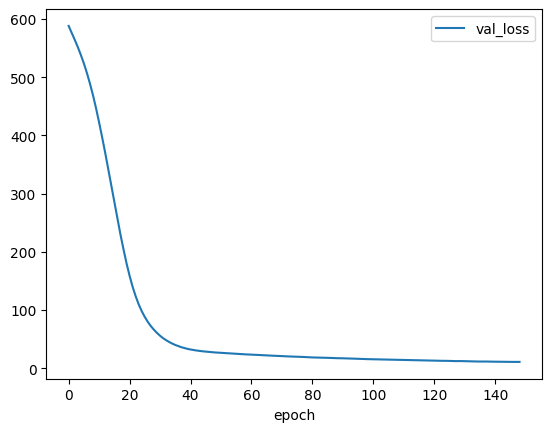

In [7]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv")) # reads the training metrics from the CSV file generated by the CSVLogger during training, which contains information about the training and validation loss for each epoch, as well as any other logged metrics ( in this case, we are interested in the validation loss to monitor the model's performance on unseen data during training )
plot = metrics[["epoch", "val_loss"]].set_index("epoch").plot() # creates a plot of the validation loss over epochs using pandas' built-in plotting functionality, which allows us to visualize how the model's performance on the validation set changes over time during training ( we can look for trends such as decreasing validation loss, which indicates that the model is learning and improving its predictions on unseen data )

Given that the `val_loss` has flatlined (it is no longer going down), the early stop callback has stopped the training process.

Now let's run the model against the test data and get an indication for how well it is performing. A typical metric for regression models is R-squared which is the proportion of the variation in the target that is predictable from the features. In other words, how well can the target be predicted using the features. An R-squared closer to 0.0 is worse and closer to 1.0 is better.

In [8]:
score = trainer.test(model, datamodule=datamodule) # evaluates the model on the test set using the test_step method defined in the RegressionModel class, which calculates the R^2 score for the test set and logs it for evaluation after training is complete

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Fontys\Year 2\Semester 4\Lab assignments\House Price Predictor\house_price_predictor\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 15.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_r2             0.783476710319519
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


A regplot shows how well the predictions of the model align with the truth values. Dots on or close ot the line are good predictions whereas if dots are scatterd away from the line it indicates that our model is not doing well. The shaded area represents the expected confidence interval and dots within the shaded area are considered close to the line. Morever, this plot shows that our model does reasonably well for houses priced between 15000 and 30000 but does a bit less good for houses that are more expensive or cheaper, as dots appear farther away from the line in those price ranges.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Fontys\Year 2\Semester 4\Lab assignments\House Price Predictor\house_price_predictor\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 77.27it/s]


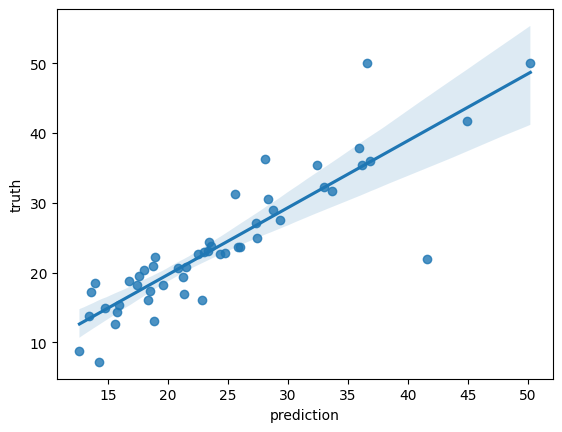

In [9]:
dataloader = datamodule.test_dataloader()
output = trainer.predict(model, dataloaders=dataloader)
predictions = torch.cat(output)
results = [[round(truth[1].item(),1), round(prediction.item(),1)] for truth, prediction in zip(dataloader.dataset, predictions)]
df = pandas.DataFrame(results, columns=["truth", "prediction"])
plot = seaborn.regplot(data=df, y="truth", x="prediction")

Here we print out all truth values, predicted values and the error (absolute difference between them) for all 50 items in the test data.

In [10]:
df["error"] = abs(df["truth"] - df["prediction"]) # calculates the absolute error for each prediction by taking the absolute difference between the true house price ( "truth" column ) and the predicted house price ( "prediction" column ) and stores it in a new column called "error" in the DataFrame
df

,truth,prediction,error
0,18.5,13.9,4.6
1,27.1,27.3,0.2
2,22.6,22.5,0.1
3,14.3,15.7,1.4
4,25.0,27.4,2.4
5,17.2,13.6,3.6
6,21.0,18.7,2.3
7,18.2,19.6,1.4
8,23.1,23.3,0.2
9,16.1,18.3,2.2


# Model Evaluation & Error Analysis

## 1️⃣ Overall Performance Metrics (R² and RMSE)

Before analyzing specific error patterns, we compute global performance metrics to establish a quantitative baseline of model performance.

We use:

- **R² (Coefficient of Determination)** to measure how much variance in house prices is explained by the model.
- **RMSE (Root Mean Squared Error)** to quantify the average prediction error in the same unit as the target ($1000s).

`R²` provides a statistical measure of explanatory power, while `RMSE` provides practical interpretability in real-world units.

We compute these metrics using `NumPy / scikit-learn` to ensure standardized and reliable regression evaluation.


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R²
r2 = r2_score(df["truth"], df["prediction"])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df["truth"], df["prediction"]))

print("Test R²:", round(r2, 4))
print("Test RMSE (in $1000s):", round(rmse, 4))

Test R²: 0.7732
Test RMSE (in $1000s): 4.4079


## 2️⃣ Distribution of Absolute Errors

While overall metrics summarize performance, they do not reveal how errors are distributed across individual predictions.

To investigate this, we visualize the absolute prediction errors using a `histogram`.

A `histogram` is chosen because it:

- Reveals the `shape` of the error distribution
- Highlights potential `lack of symmetry`
- Exposes the presence of `extreme outliers`
- Shows whether most predictions cluster near low error values

This allows us to assess whether the model performs consistently or if a small number of large errors dominate the RMSE.


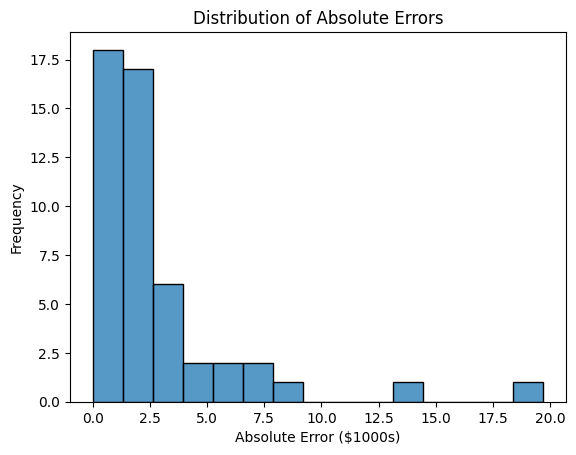

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(df["error"], bins=15)
plt.title("Distribution of Absolute Errors")
plt.xlabel("Absolute Error ($1000s)")
plt.ylabel("Frequency")
plt.show()

**Interpretation:**

The histogram shows that most prediction errors fall below approximately `$5,000`, indicating reasonable performance for the majority of houses.

However, the distribution is right-skewed, with a small number of large errors exceeding `$10,000`. These extreme errors disproportionately influence the RMSE due to the squared error term.

This suggests that the model performs consistently for mid-range properties but struggles with extreme or high-priced houses.

## 3️⃣ Residual Analysis

While absolute errors show the magnitude of prediction mistakes, residuals (truth − prediction) reveal whether the model systematically over/under-predicts.

In a well-fitted regression model, residuals should be randomly distributed around zero without clear patterns. Any visible structure may indicate missing relationships or model bias.

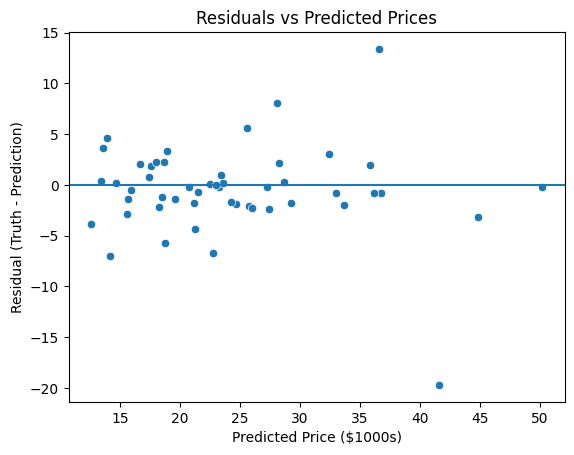

In [14]:
df["residual"] = df["truth"] - df["prediction"]

plt.figure()
sns.scatterplot(x=df["prediction"], y=df["residual"])
plt.axhline(0)
plt.title("Residuals vs Predicted Prices")
plt.xlabel("Predicted Price ($1000s)")
plt.ylabel("Residual (Truth - Prediction)")
plt.show()

**Interpretation:**

The residual plot shows that most residuals are centered around zero, indicating no strong overall bias.

However, the spread of residuals increases for higher predicted prices, suggesting `heteroscedasticity` — the model's prediction variance grows for more expensive houses.

Additionally, several large positive residuals indicate systematic underprediction of high-priced properties. This suggests that the model 
struggles to accurately capture extreme values in the dataset.

# Model Improvement Strategy

## 1️⃣ Attempt 1: Logarithmic Transformation of the Target

From the residual analysis, we observed increasing prediction variance for higher-priced houses, indicating `heteroscedasticity`.

A common statistical remedy for heteroscedasticity is to apply a logarithmic transformation to the target variable. Log transformation compresses `large values`, reduces `right-skewness`, and often stabilizes variance in `regression problems`.

Therefore, we trained the model on log(medv) and converted predictions back to the original scale using the exponential function.

### Outcome

Although theoretically sound, this transformation significantly 
`degraded` performance in original price space:

- R² became `negative`
- RMSE `increased` substantially
- Predictions for high-priced houses became `unstable`

This occurred because minimizing squared error in log space does not guarantee minimized squared error in original price space. 
Exponentiation amplifies small log-space errors into large absolute-scale deviations.

As a result, this approach was `rejected`.

## 2️⃣ Attempt 2: Feature Standardization

Neural networks are highly sensitive to feature scale because gradient updates depend on input magnitude.

The Boston dataset contains features with vastly different ranges (e.g., tax vs rm vs crim), which can destabilize training and bias gradient descent.

To address this, we applied `standardization` to the input features using `StandardScaler`, fitted only on the training set 
to prevent `data leakage`.

### Outcome

After feature scaling:

- R² improved from 0.621 to 0.773
- RMSE decreased from 5.7 to 4.4 ($1000s)
- Residual variance reduced
- Error distribution became more concentrated

This confirms that feature standardization significantly `improves` neural network performance in this regression task.
